In [1]:
from utils import *

In [2]:
c1 = create_sensor(sensor_number=1)
c2 = create_sensor(sensor_number=2)
c3 = create_sensor(sensor_number=3)

# Extract projection matrices from sensors
c1pose_actual = np.array(c1['to_world'].matrix)[:3,:]
c2pose_actual = np.array(c2['to_world'].matrix)[:3,:]
c3pose_actual = np.array(c3['to_world'].matrix)[:3,:]
actual_poses = np.stack([c1pose_actual, c2pose_actual, c3pose_actual])

# Load the estimated pose matrices computed using PnP
estimated_poses_loc = "outputs/estimated_pose_matrices/"
c1pose_estimated = np.load(estimated_poses_loc+"c1posep.npy")
c2pose_estimated = np.load(estimated_poses_loc+"c2posep.npy")
c3pose_estimated = np.load(estimated_poses_loc+"c3posep.npy")
estimated_poses = np.stack([c1pose_estimated, c2pose_estimated, c3pose_estimated])

print(actual_poses)
print("\n\n")
print(estimated_poses)

[[[-6.56510830e-01 -7.29643881e-01  1.91346124e-01 -5.96334600e+00]
  [-6.56510830e-01  6.77617311e-01  3.31403643e-01 -1.03287039e+01]
  [-3.71466011e-01  9.19492841e-02 -9.23882246e-01  1.78488827e+01]]

 [[ 9.23874855e-01 -8.44208353e-06 -3.82694721e-01  1.19286947e+01]
  [ 0.00000000e+00 -1.00000000e+00  2.20595775e-05 -2.20595775e-05]
  [-3.82694721e-01 -2.03802883e-05 -9.23874855e-01  1.78498745e+01]]

 [[-6.56507790e-01  7.29646504e-01  1.91346720e-01 -5.96384668e+00]
  [ 6.56507790e-01  6.77613378e-01 -3.31417680e-01  1.03296175e+01]
  [-3.71476769e-01 -9.19576734e-02 -9.23877120e-01  1.78518772e+01]]]



[[[-6.65349617e-01 -7.27069749e-01  1.69350134e-01 -5.48422285e+00]
  [-6.61127475e-01  6.79231711e-01  3.18676552e-01 -1.00443669e+01]
  [-3.46728062e-01  1.00069295e-01 -9.32612346e-01  1.79380601e+01]]

 [[ 9.24374621e-01 -1.63462428e-02 -3.81135621e-01  1.17532807e+01]
  [-4.12775009e-03 -9.99451650e-01  3.28536386e-02 -7.33065051e-01]
  [-3.81463658e-01 -2.87958371e-02 -9

In [3]:
for i in range(actual_poses.shape[0]):
    R_a = actual_poses[i,:,:3]
    T_a = actual_poses[i,:,-1]
    R_e = estimated_poses[i,:,:3]
    T_e = estimated_poses[i,:,-1]

    position_diff = np.linalg.norm(T_e - T_a)
    rotation_diff = get_cosine_angle_between_matrices(R_a, R_e)
    
    print("Camera "+str(i+1)+":")
    print("Position Error:", position_diff, "cm")
    print("Rotation Error:", rotation_diff, "deg")
    print()

Camera 1:
Position Error: 0.5642332375026607 cm
Rotation Error: 1.5735712015457395 deg

Camera 2:
Position Error: 0.8159017801673913 cm
Rotation Error: 1.8979553646844372 deg

Camera 3:
Position Error: 0.4400435455858636 cm
Rotation Error: 1.200778207723021 deg



In [4]:
cparams = {
    'radius': 11.0,
    'height': 14.0,
    'rcount': 8,
    'mtcount': 45,
    'hcount':  5,
    'origin': [0.0, 0.0, -12.0],
}

# cparams = default_cylindrical_grid_params
grid = generate_cylindrical_grid(**cparams)
print(len(grid))
# visualize_grid(grid)

1000


In [5]:
# visualize_grid_2d(grid)
print(np.max(np.array(grid)[:,0]))

11.0


In [6]:
# project the points directly onto the image plane using the actual camera poses
actualp1 = []
actualp2 = []
actualp3 = []
inv_actual_poses = compute_inverse_pose_matrices(actual_poses)
for point in grid:
    actualp1.append(normalized_to_pixel(reproject(inv_actual_poses[0], point)))
    actualp2.append(normalized_to_pixel(reproject(inv_actual_poses[1], point)))
    actualp3.append(normalized_to_pixel(reproject(inv_actual_poses[2], point)))
actualp1 = np.array(actualp1)
actualp2 = np.array(actualp2)
actualp3 = np.array(actualp3)

In [7]:
# use n-view triangulation to determine the localization. However, use the estimated poses to shoot the rays
predictions = []
for i in range(len(grid)):
    clocs = np.stack([actualp1[i], actualp2[i], actualp3[i]])
    clocs = np.array([normalize_coordinate(c) for c in clocs])
    predictions.append(n_view_triangulate(estimated_poses, clocs))
predictions = np.array(predictions)

# Calculate the triangulation errors (in centimeters)
errors = []
i = 0
for pred in predictions:
    errors.append(np.linalg.norm(pred - grid[i]))
    i += 1
errors = np.array(errors)

Max error (cm): 0.41316048848197995
Average error (cm):  0.20782910013616765


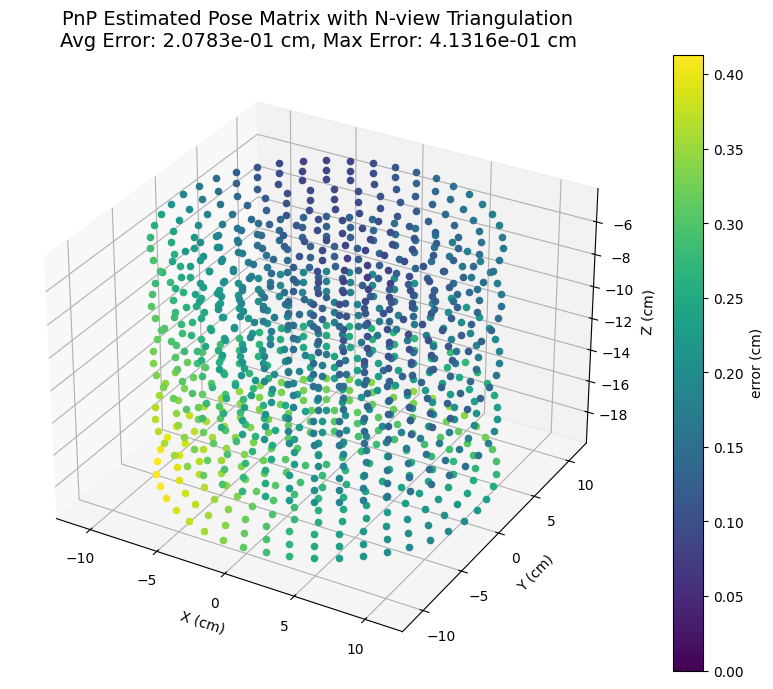

In [16]:
vmax = np.max(errors)
print("Max error (cm):", vmax)
avgerr = np.average(errors)
print("Average error (cm): ", avgerr)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')
ax.set_title("PnP Estimated Pose Matrix with N-view Triangulation\nAvg Error: "+"{:.4e}".format(avgerr)+" cm, Max Error: "+"{:.4e}".format(vmax)+" cm", fontsize=14)
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Z (cm)')

i = 0
sc = None
for point in grid:
    sc = ax.scatter(point[0], point[1], point[2], c=errors[i], cmap='viridis', vmin=0, vmax=vmax)
    i += 1
fig.colorbar(sc, label="error (cm)")

0.20782910013616765
0.0775058459032647


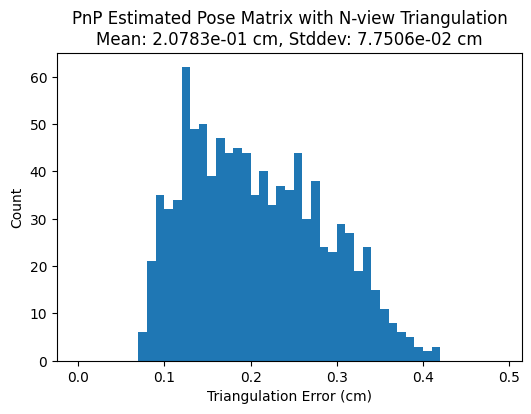

In [9]:
# Round max up to closest tenths place in error. 10 left-aligned bins per 0.1cm interval
bins = np.arange(int(np.max(errors)*10+1)*10)/100
plt.figure(figsize=(6,4))
plt.hist(errors, bins=bins)
plt.xlabel("Triangulation Error (cm)")
plt.ylabel("Count")
plt.title("PnP Estimated Pose Matrix with N-view Triangulation\nMean: " + "{:.4e}".format(np.mean(errors)) + " cm, Stddev: " + "{:.4e}".format(np.std(errors)) + " cm")
print(np.mean(errors))
print(np.std(errors))

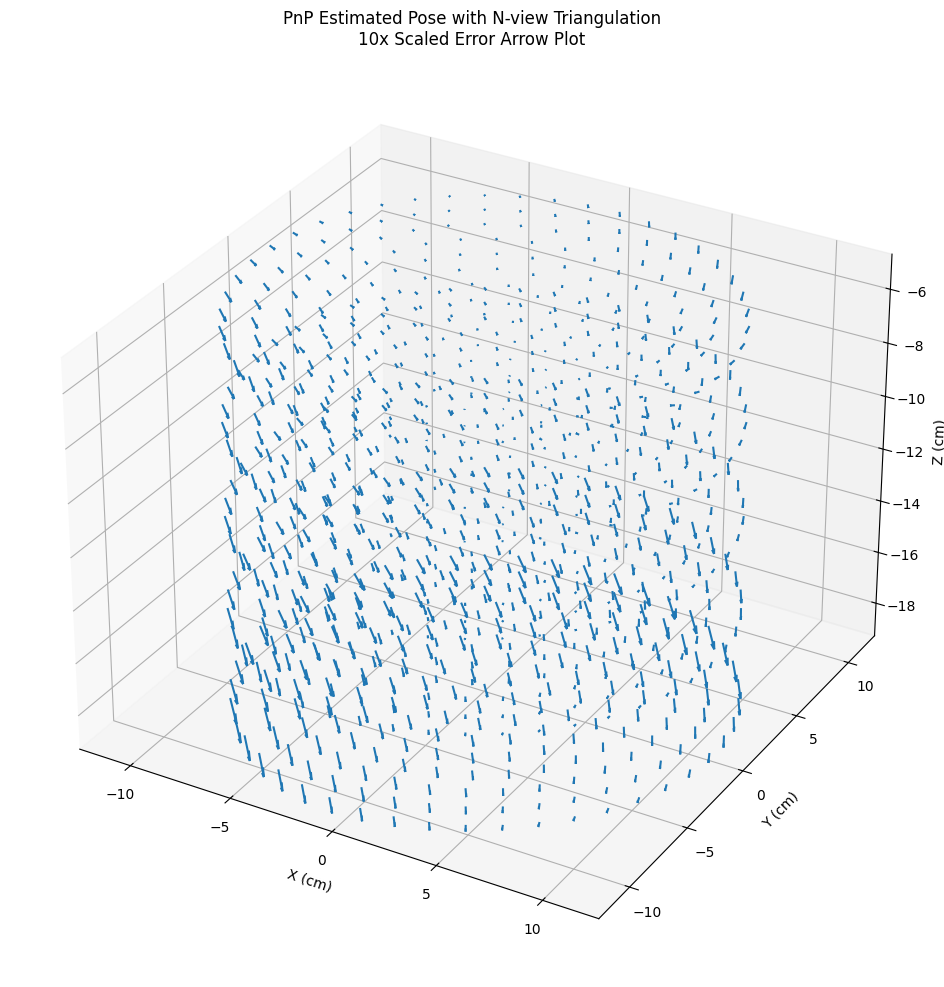

In [13]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel("X (cm)")
ax.set_ylabel("Y (cm)")
ax.set_zlabel("Z (cm)")
ax.set_title("PnP Estimated Pose with N-view Triangulation\n10x Scaled Error Arrow Plot")

i = 0
for pred in predictions:
    if np.all(pred != None):
        point = grid[i]
        dir = pred - point
        ldir = np.linalg.norm(dir) * 10 # 10x length to make errors move visible
        ax.quiver(point[0], point[1], point[2], dir[0], dir[1], dir[2],
                  pivot='tail', length=ldir, arrow_length_ratio=0.3)
    i += 1
